## Question 1

In [2]:
import numpy as np
from qat.lang.AQASM import Program, H,  AbstractGate, QRoutine, CNOT
from scipy import linalg # for linalg.expm, the matrix exponential.
from qat.qpus import get_default_qpu # numerical simulator for small quantum circuits.

# PUT YOUR IMPLEMENTATION HERE. Take inspiration from the "minimal notebook" that was sent to you.

prog = Program() # The object we use to "accumulate" the gates when building the circuits

q = prog.qalloc(2) # Allocation of a register of 2 qubits called q. It is addressable with [.] like an array.
                   # We will only work with one register in this session, but defining several is possible !

prog.apply(H, q[0]) # The first instruction of the program is the application of an Hadamard gate onto q[0]

def matrix(theta):
    X = np.array([[0,1],[1,0]])
    return linalg.expm(-1j * theta * X)

ham_x = AbstractGate("ham_X", [float], arity=1, matrix_generator=matrix) # definition of a custom parametrized gate

prog.apply(ham_x(0.3).ctrl(), q) # The third instuction is the application of our custom gate onto q

circ = prog.to_circ() # The program is exported into a circuit.  

prog.apply(CNOT, q)

# displaying the circuit:
%qatdisplay --svg circ

### Hamiltonian data

The purpose of the TP is to reproduce, using numerical simulation, Figure 3.(a) of https://arxiv.org/abs/1512.06860.

On this figure, the ground state energy of a dihydrogen molecule is plotted against the distance $R$ separating the hydrogen atoms. It allows to predict the **equilibrium bond length** of the molecule.

*Note*: In more complicated settings with larger molecules, energy may be plotted against various distances and angles, forming an *energy landscape* that proves useful in predicting chemical reaction mechanisms, rates, etc.

The cell below imports the data of Table I of https://arxiv.org/abs/1512.06860.

In [3]:
#importing Hamiltonian data.
import json 

with open('hamiltonian_data.json','r') as f:
    ham_data = json.load(f)
    
for coeffs in ham_data:
    print(coeffs)

{'R': 0.2, 'I_coeff': 2.8489, 'Z0_coeff': 0.5678, 'Z1_coeff': -1.4508, 'Z0Z1_coeff': 0.6799, 'X0X1_coeff': 0.0791, 'Y0Y1_coeff': 0.0791, 't0': 0.0791}
{'R': 0.25, 'I_coeff': 2.1868, 'Z0_coeff': 0.5449, 'Z1_coeff': -1.287, 'Z0Z1_coeff': 0.6719, 'X0X1_coeff': 0.0798, 'Y0Y1_coeff': 0.0798, 't0': 0.0798}
{'R': 0.3, 'I_coeff': 1.7252, 'Z0_coeff': 0.5215, 'Z1_coeff': -1.1458, 'Z0Z1_coeff': 0.6631, 'X0X1_coeff': 0.0806, 'Y0Y1_coeff': 0.0806, 't0': 0.0806}
{'R': 0.35, 'I_coeff': 1.3827, 'Z0_coeff': 0.4982, 'Z1_coeff': -1.0226, 'Z0Z1_coeff': 0.6537, 'X0X1_coeff': 0.0815, 'Y0Y1_coeff': 0.0815, 't0': 0.0815}
{'R': 0.4, 'I_coeff': 1.1182, 'Z0_coeff': 0.4754, 'Z1_coeff': -0.9145, 'Z0Z1_coeff': 0.6438, 'X0X1_coeff': 0.0825, 'Y0Y1_coeff': 0.0825, 't0': 0.0825}
{'R': 0.45, 'I_coeff': 0.9083, 'Z0_coeff': 0.4534, 'Z1_coeff': -0.8194, 'Z0Z1_coeff': 0.6336, 'X0X1_coeff': 0.0835, 'Y0Y1_coeff': 0.0835, 't0': 0.0835}
{'R': 0.5, 'I_coeff': 0.7381, 'Z0_coeff': 0.4325, 'Z1_coeff': -0.7355, 'Z0Z1_coeff': 0.6233,

### Question 2:
Following the QRoutine minimal example below, implement QRoutines for each of the Hamiltonian evolutions we need.


#### QRoutine: minimal example

In [4]:
from qat.lang.AQASM import RZ
def f(dt):
    
    routine = QRoutine()
    
    routine.apply(RZ(dt), 0)            # like a Program, except that gates are applied to "wires" 
    routine.apply(CNOT, 0, 1)           # numbered from 0 to the max number that has been seen.
    routine.apply(H, 0)
    
    return routine

#Pasting it into a circuit

prog = Program()

q = prog.qalloc(4)

a = f(0.1)

prog.apply(a, q[:2])
prog.apply(f(0.2), q[1:3])
prog.apply(f(0.3).ctrl(), q[1:]) #Controlled version

circ = prog.to_circ()

%qatdisplay --svg circ        

#### Hamiltonian evolutions to implement

In [15]:
from qat.lang.AQASM import CNOT, RZ, RX, RY, S, I

def u_11_matrix(dt):
    # needed for accurate energy values.
    return np.diag([np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt)])

U_II = AbstractGate("II",[float],arity=2,matrix_generator=u_11_matrix)
    
def U_ZZ(dt):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(2*dt), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

#Implement, as above, all the other hamiltonian simulations here.
def U_ZI(dt):
    
    zi_r = QRoutine()
    zi_r.apply(RZ(2*dt), 0)
    zi_r.apply(I, 1)
    return zi_r

def U_IZ(dt):
    
    iz_r = QRoutine()
    iz_r.apply(RZ(2*dt), 1)
    iz_r.apply(I, 0)    
    return iz_r    

def U_XX(dt):
    
    xx_r = QRoutine()
    xx_r.apply(CNOT, 0, 1)
    xx_r.apply(RX(2*dt), 0)
    xx_r.apply(CNOT, 0, 1)
    
    return xx_r


def U_YY(dt):
    
    yy_r = QRoutine()
    yy_r.apply(S.dag(), 1)
    yy_r.apply(CNOT, 0, 1)
    yy_r.apply(RY(2*dt), 0)
    yy_r.apply(CNOT, 0, 1)
    yy_r.apply(S, 1)
    
    return yy_r
    
    
check = True # turn true to plot and see what you do

if check:
    prog = Program()
    q = prog.qalloc(2)
    prog.apply(U_YY(3.), q)
    circ = prog.to_circ()

    #uncomment following line to plot circuit
    %qatdisplay --svg circ

### Question 3:
Implement a function returning a Qroutine implementing a Trotterized evolution generated by our Hamiltonian.

In [16]:
def trotter_ham_simulation(ham_coeffs, dt, p, shift):
    """
    Args:
        - ham_coeffs: a dictionary from the list of dictionaries loaded from hamiltonian_data.json.
        Therefore its keys are "I_coeff", "Z0_coeff", etc.
        - dt: a float, corresponding to the interval of time whose value we will define later.
        - p: the "Trotter number": the integer controlling the degree of approximation
        - shift: an energy shift to the Hamiltonian to make sure that the value of the ground state energy
        is positive. It consists in adding +shift*I to the Hamiltonian.
    """
    qroutine = QRoutine()
    print(2*dt*ham_coeffs['X0X1_coeff']/p)
    Gates = [U_XX(2*dt*ham_coeffs['X0X1_coeff']/p),
             U_YY(2*dt*ham_coeffs['Y0Y1_coeff']/p),
             U_ZZ(2*dt*ham_coeffs['Z0Z1_coeff']/p), 
             U_IZ(2*dt*ham_coeffs['Z1_coeff']/p), 
             U_ZI(2*dt*ham_coeffs['Z0_coeff']/p), 
             U_II(2*dt*ham_coeffs['I_coeff']/p)]

    # Hint: gates are regular python objects, they can be put in a list.
    for k in range(p) :
        for gate in Gates :
            qroutine.apply(gate, 0, 1)
            
    return qroutine

In [17]:
# IDEAL HAMILTONIAN SIMULATION: we will use it to compare to the Trotterized version.
def perfect_ham_simulation(ham_coeffs, dt, shift):

    I = np.eye(4)
    Z0 = np.diag([1,1,-1,-1])
    Z1 = np.diag([1,-1,1,-1])
    Z0Z1 = np.diag([1,-1,-1,1])
    X0X1= np.fliplr(np.eye(4))
    Y0Y1 = np.fliplr(np.diag([-1, 1, 1, -1]))

    H = (ham_coeffs['I_coeff']+shift) * I
    H += ham_coeffs['Z0_coeff'] * Z0
    H += ham_coeffs['Z1_coeff'] * Z1
    H += ham_coeffs['Z0Z1_coeff'] * Z0Z1
    H += ham_coeffs['X0X1_coeff'] * X0X1
    H += ham_coeffs['Y0Y1_coeff'] * Y0Y1

    U = linalg.expm(-1j * dt * H)

    def matrix():
        return U

    U_gate = AbstractGate("U", [], arity=2,
                     matrix_generator=matrix)

    qroutine = QRoutine()

    qroutine.apply(U_gate(), 0, 1)

    return qroutine

### Question 4: Implement iterative phase estimation
As a function taking as input an Hamiltonian and execution parameters, and returning a phase.

In [21]:
from qat.lang.AQASM import X

E_max = 3
E_min = -2
    
dt = (2 * np.pi) / float(E_max)

def phase(coeffs, trotterization=False, trotter_number=4, shift=-E_min, nBits = 10):
    """
    Given Hamiltonian coefficients, compute phi, s.t U|\psi\rangle = e^{-2i\pi\phi}|\psi\rangle
    
    Args:
        - coeffs: a dictionary of coefficients as extracted from the list of dictionaries loaded
        from hamiltonian_data.json
        - trotterization: Boolean flag specifying whether to use the Trotterized evolution or the
        ideal "cheat mode" which exponentiates the Hamiltonian.
        - trotter_number: the "p" controlling the degree of approximation of the Trotterization.
        - shift: the energy shift that we use to make sure that the phase we compute is 0 < phi < 1
        - nBits: The number of precision bits we compute.
        
    Returns:
        - phi, a real number that should fall between 0 and 1.
    """
    bits = {}

    for k in range(nBits, 0, -1):
        
        # CIRCUIT CREATION
        # Put your implementation here. Paste here the QRoutines 
        prog = Program()
        q = prog.qalloc(3)
        
        phi = 0
        for i in range(k+1, nBits+1):
            phi += bits[i]/2**(i-k+1)
        phi = 2*np.pi*phi
        
        prog.apply(X, q[1])
        
        # run the circuit
        prog.apply(H, q[0])
        
        if trotterization:
            prog.apply(trotter_ham_simulation(coeffs, 2**(k-1)*dt, trotter_number, shift).ctrl(), q)
        else:
            prog.apply(perfect_ham_simulation(coeffs, 2**(k-1)*dt, shift).ctrl(), q)
        
        prog.apply(RZ(phi), q[0])
        prog.apply(H, q[0])
        
        # CIRCUIT SIMULATION
        qpu = get_default_qpu()
        job = prog.to_circ().to_job(qubits=[0])

        result = qpu.submit(job)

        # SELECTION OF MOST LIKELY RESULT 
        # Put your implementation here
        state = 0
        proba = 0
        for sample in result:
            if sample.probability >= proba:
                state = sample.state.int
                proba = sample.probability        
        
        
        bits[k] = state
           
    # recompute phi
    phi = 2 * np.pi * sum([bits[l] / 2**(l) for l in range(1, nBits+1)])
            
    return phi

### Question 5: Plot dissociation curves
Call the function you defined above to compute phases for each values of R. Convert them back to energies, and plot the result for two different Trotter number values: 4 and 10. Both should be wiggly approximations to the ideal curve, but 10 should be closer to it.

In [22]:
vals_perfect = []
vals_trotter_4 = []
vals_trotter_10 = []
Rs = []

shift = -E_min

for coeffs in ham_data:
    phi_perfect = phase(coeffs)
    phi_trotter_4 = phase(coeffs, trotterization=True, trotter_number=4)
    phi_trotter_10 = phase(coeffs, trotterization=True, trotter_number=10)

    # CONVERT PHASES BACK TO ENERGY
    E = 2 * np.pi * phi_perfect / dt
    E_trotter_4 = 2 * np.pi * phi_trotter_4 / dt
    E_trotter_10 = 2 * np.pi * phi_trotter_10 / dt
    print("R", coeffs['R'])
    Rs.append(coeffs['R'])
    
    vals_perfect.append(E)
    vals_trotter_4.append(E_trotter_4)
    vals_trotter_10.append(E_trotter_10)


42.41066306542125
21.205331532710623
10.602665766355312
5.301332883177656
2.650666441588828
1.325333220794414
0.662666610397207
0.3313333051986035
0.16566665259930174
0.08283332629965087
16.9642652261685
8.48213261308425
4.241066306542125
2.1205331532710625
1.0602665766355313
0.5301332883177656
0.2650666441588828
0.1325333220794414
0.0662666610397207
0.03313333051986035
R 0.2
42.7859786677701
21.39298933388505
10.696494666942526
5.348247333471263
2.6741236667356314
1.3370618333678157
0.6685309166839078
0.3342654583419539
0.16713272917097696
0.08356636458548848
17.114391467108042
8.557195733554021
4.278597866777011
2.1392989333885053
1.0696494666942526
0.5348247333471263
0.26741236667356316
0.13370618333678158
0.06685309166839079
0.033426545834195395
R 0.25
43.21491078474023
21.607455392370117
10.803727696185058
5.401863848092529
2.7009319240462646
1.3504659620231323
0.6752329810115661
0.3376164905057831
0.16880824525289154
0.08440412262644577
17.285964313896095
8.642982156948047
4.3214

1.7877756594028316
0.8938878297014158
0.4469439148507079
0.22347195742535395
0.11173597871267697
22.883528440356244
11.441764220178122
5.720882110089061
2.8604410550445305
1.4302205275222653
0.7151102637611326
0.3575551318805663
0.17877756594028316
0.08938878297014158
0.04469439148507079
R 1.25
58.06668533483086
29.03334266741543
14.516671333707714
7.258335666853857
3.6291678334269286
1.8145839167134643
0.9072919583567322
0.4536459791783661
0.22682298958918304
0.11341149479459152
23.22667413393234
11.61333706696617
5.806668533483085
2.9033342667415427
1.4516671333707714
0.7258335666853857
0.36291678334269284
0.18145839167134642
0.09072919583567321
0.045364597917836605
R 1.3
58.97816608339238
29.48908304169619
14.744541520848095
7.372270760424048
3.686135380212024
1.843067690106012
0.921533845053006
0.460766922526503
0.2303834612632515
0.11519173063162574
23.591266433356953
11.795633216678477
5.897816608339238
2.948908304169619
1.4744541520848096
0.7372270760424048
0.3686135380212024
0.

7.345462503113415
3.6727312515567077
1.8363656257783538
0.9181828128891769
0.45909140644458846
0.22954570322229423
0.11477285161114711
0.05738642580557356
R 2.3
74.04440669196806
37.02220334598403
18.511101672992016
9.255550836496008
4.627775418248004
2.313887709124002
1.156943854562001
0.5784719272810005
0.28923596364050025
0.14461798182025012
29.617762676787226
14.808881338393613
7.4044406691968065
3.7022203345984033
1.8511101672992016
0.9255550836496008
0.4627775418248004
0.2313887709124002
0.1156943854562001
0.05784719272810005
R 2.35
74.63418835280198
37.31709417640099
18.658547088200496
9.329273544100248
4.664636772050124
2.332318386025062
1.166159193012531
0.5830795965062655
0.29153979825313275
0.14576989912656638
29.853675341120795
14.926837670560397
7.463418835280199
3.7317094176400993
1.8658547088200497
0.9329273544100248
0.4664636772050124
0.2332318386025062
0.1166159193012531
0.05830795965062655
R 2.4
75.17035349901465
37.585176749507326
18.792588374753663
9.396294187376832

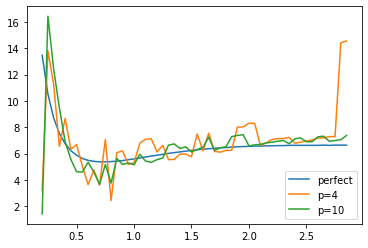

In [23]:
import matplotlib.pylab as plt

plt.plot(Rs, vals_perfect, label="perfect")
plt.plot(Rs, vals_trotter_4, label="p=4")
plt.plot(Rs, vals_trotter_10, label="p=10")
plt.legend()